In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statistics
from pandasql import sqldf

In [2]:
# Make your pysqldf object to run SQL commands on a padas df
pysqldf = lambda q: sqldf(q, globals())

In [3]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    421570 non-null  int64  
 1   index         421570 non-null  int64  
 2   Store         421570 non-null  int64  
 3   Dept          421570 non-null  int64  
 4   Date          421570 non-null  object 
 5   IsHoliday     421570 non-null  int64  
 6   Weekly_Sales  421570 non-null  float64
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  Type          421570 non-null  object 
 17  Size          421570 non-null  int64  
dtypes: f

In [5]:
train.tail()

,Unnamed: 0,index,Store,Dept,Date,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421565,421565,421565,45,98,2012-09-28,0,508.37,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,421566,421566,45,98,2012-10-05,0,628.10,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,421567,421567,45,98,2012-10-12,0,1061.02,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,421568,421568,45,98,2012-10-19,0,760.01,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221
421569,421569,421569,45,98,2012-10-26,0,1076.80,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221


In [6]:
# Write your query in SQL syntax, this will treat your pandas df as a normal SQL table
sql_call= """
    SELECT *
    
    FROM train

    WHERE Dept = 12 AND Store = 12;
"""
# get sql query results as a dataframe using the sqldf object that you created
dept_df = pysqldf(sql_call)

In [7]:
dept_df = dept_df.iloc[:, 1:]
dept_df.head()

,index,Store,Dept,Date,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,109474,12,12,2010-02-05,0,5711.57,49.47,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,13.975,B,112238
1,109475,12,12,2010-02-12,1,5427.79,47.87,2.946,NaN,NaN,NaN,NaN,NaN,126.496258,13.975,B,112238
2,109476,12,12,2010-02-19,0,5451.57,54.83,2.915,NaN,NaN,NaN,NaN,NaN,126.526286,13.975,B,112238
3,109477,12,12,2010-02-26,0,6262.36,50.23,2.825,NaN,NaN,NaN,NaN,NaN,126.552286,13.975,B,112238
4,109478,12,12,2010-03-05,0,6437.56,53.77,2.987,NaN,NaN,NaN,NaN,NaN,126.578286,13.975,B,112238


In [8]:
sales = ['Date', 'Weekly_Sales']
temp = ['Date', 'Temperature']
fuel = ['Date', 'Fuel_Price']

Xs = dept_df[sales]
Xs.set_index("Date", inplace = True)

Xt = dept_df[temp]
Xt.set_index("Date", inplace = True)

Xf = dept_df[fuel]
Xf.set_index("Date", inplace = True)

print(Xs.shape, Xt.shape, Xf.shape)

(143, 1) (143, 1) (143, 1)


## SALES TIMESERIES MODEL

In [9]:
Xs.shape

(143, 1)

In [10]:
Xs.head()

,Weekly_Sales
Date,
2010-02-05,5711.57
2010-02-12,5427.79
2010-02-19,5451.57
2010-02-26,6262.36
2010-03-05,6437.56


In [11]:
#defining data to Train, Validate splits
train_X = Xs.iloc[:123,]
val_X = Xs.iloc[123:,]

In [12]:
train_X.shape, val_X.shape

((123, 1), (20, 1))

In [13]:
train_X = train_X.rename(columns={"Weekly_Sales":"ws"})
train_X.tail()

,ws
Date,
2012-05-11,4920.88
2012-05-18,5045.48
2012-05-25,4753.03
2012-06-01,4639.85
2012-06-08,5960.55


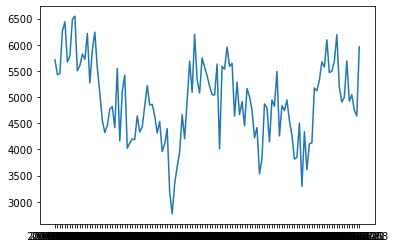

In [14]:
#plt.figure(figsize=(18,18))
plt.plot(train_X.ws)
plt.show()

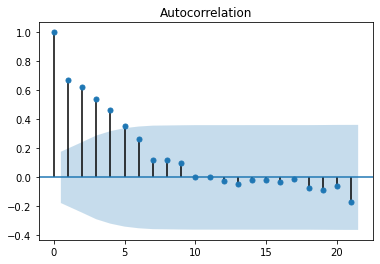

In [15]:
plot_acf(train_X.ws)
plt.show()

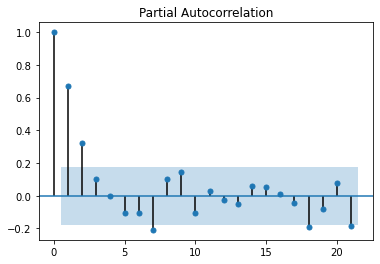

In [16]:
plot_pacf(train_X.ws)
plt.show()

## BUILD SIMPLE MODEL FIT

In [17]:
ARMA1_model = ARIMA(train_X, order=(1,1,1)).fit(transparams=False)

C:\Users\Field Employee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\Field Employee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


In [18]:
print(ARMA1_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.ws   No. Observations:                  122
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -941.731
Method:                       css-mle   S.D. of innovations            544.087
Date:                Mon, 28 Sep 2020   AIC                           1891.462
Time:                        16:05:40   BIC                           1902.678
Sample:                    02-12-2010   HQIC                          1896.018
                         - 06-08-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8566     27.657     -0.067      0.946     -56.062      52.349
ar.L1.D.ws    -0.1317      0.188     -0.702      0.483      -0.500       0.236
ma.L1.D.ws    -0.3686      0.174     -2.116      0.0

In [19]:
ARMA1_predict = ARMA1_model.predict('2012-06-08','2012-10-26', typ='levels')

In [20]:
print('FORECAST PREDICTIONS')
print(ARMA1_predict)

FORECAST PREDICTIONS
2012-06-08    4751.889874
2012-06-15    5339.007200
2012-06-22    5418.774045
2012-06-29    5406.166201
2012-07-06    5405.725712
2012-07-13    5403.682570
2012-07-20    5401.850526
2012-07-27    5399.990676
2012-08-03    5398.134489
2012-08-10    5396.277820
2012-08-17    5394.421214
2012-08-24    5392.564599
2012-08-31    5390.707986
2012-09-07    5388.851373
2012-09-14    5386.994759
2012-09-21    5385.138146
2012-09-28    5383.281533
2012-10-05    5381.424919
2012-10-12    5379.568306
2012-10-19    5377.711692
2012-10-26    5375.855079
Freq: W-FRI, dtype: float64


In [21]:
pred_vals = pd.DataFrame(ARMA1_predict, columns=['ws'], index=['2012-06-08', '2012-06-15', '2012-06-22', 
                                                   '2012-06-29', '2012-07-06', '2012-07-13', 
                                                   '2012-07-20', '2012-07-27', '2012-08-03', 
                                                   '2012-08-10', '2012-08-17', '2012-08-24', 
                                                   '2012-08-31', '2012-09-07', '2012-09-14', 
                                                   '2012-09-21', '2012-09-28', '2012-10-05', 
                                                   '2012-10-12', '2012-10-19', '2012-10-26',
                                                  ])

In [22]:
pred_vals.tail()

,ws
2012-09-28,5383.281533
2012-10-05,5381.424919
2012-10-12,5379.568306
2012-10-19,5377.711692
2012-10-26,5375.855079


In [23]:
# append to training set
train_Plus_Pred = train_X.append(pred_vals)

In [24]:
train_Plus_Pred.shape

(144, 1)

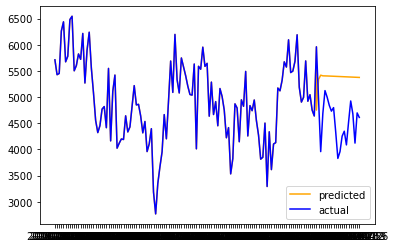

In [25]:
# plot actual vs predicted

plt.plot(train_Plus_Pred.ws, c='orange', label='predicted')
plt.plot(Xs.Weekly_Sales, c='blue', label='actual')
plt.legend(loc='lower right')
plt.show()

In [26]:
#mean absolute error to evaluate the model
actual_values_holdout = Xs.iloc[123:,]
predicted_values_holdout = train_Plus_Pred.iloc[123:,]

In [27]:
avh = actual_values_holdout.Weekly_Sales
pvh = predicted_values_holdout.ws

In [28]:
# calculating the range of prediction errors that will be used for the MAE calculation
pred_err = []
for i in range(len(actual_values_holdout)):
    err = avh[i] - pvh[i]
    pred_err.append(err)
print(pred_err)

[193.9701255557502, -1379.8872004767354, -729.8140445487661, -281.786201019343, -405.625711792537, -560.9025702096651, -669.3505258390969, -600.5506762911473, -1062.7944891690568, -1567.0078196417303, -1435.0812136555696, -1138.3145992999316, -1041.8879860466996, -1301.6113726482617, -864.8247592689495, -458.97814588711844, -702.7115325056193, -1259.6849191240763, -681.2983057425381, -765.6516923609997]


In [29]:
MAE = statistics.mean(map(abs, pred_err))
MAE

855.0866945541796

In [30]:
# look at result and decide if you would accept the model as it is
# dickey fuller test is good at helping make that decision
# one hypothesis we can test through dfuller, is whether the data was stationary or not 
# meaning we either had to much variation or the data was stationary

#augmented dickey fuller test
test_results = adfuller(train_X)

#if p-value is greater than 0.05 then the hypothesis fails
print('p-value ', test_results[1])

# find ways to fix model/ transforming the data 
# 1. stabilizing variance by apply cube root to variance
# 2. compare models with different AR and MA terms to see if results change
# 3. sample sample size

#FURTHER TOPICS TO STUDY:
# look at model diagnostics
# Use AIC to search best model parameters
# Handle any datetime data issues
# Other ARIMA modeling techniques

p-value  0.022524272542508352


## EIT ARIMA EDITION

In [31]:
Xs.shape, train_X.shape, val_X.shape

((143, 1), (123, 1), (20, 1))

In [32]:
train_X.isnull().sum()

ws    0
dtype: int64

In [33]:
train_X.head()

,ws
Date,
2010-02-05,5711.57
2010-02-12,5427.79
2010-02-19,5451.57
2010-02-26,6262.36
2010-03-05,6437.56


In [34]:
#df = df.rename(columns = {"DATE": 'ds', "IPG2211A2N": 'ts'})
train_X = train_X.rename(columns={"Weekly_Sales":"ws"})
train_X.tail()

,ws
Date,
2012-05-11,4920.88
2012-05-18,5045.48
2012-05-25,4753.03
2012-06-01,4639.85
2012-06-08,5960.55


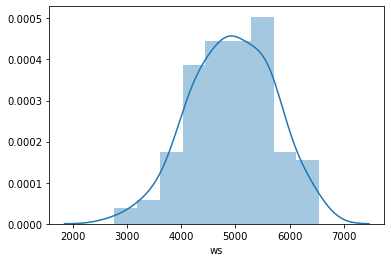

In [35]:
sns.distplot(train_X["ws"])


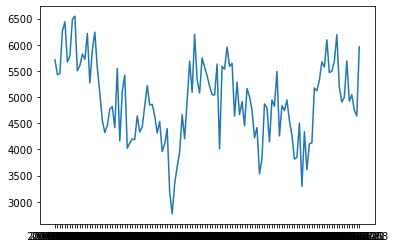

In [36]:
plt.figure()
plt.plot(train_X.ws)

In [37]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

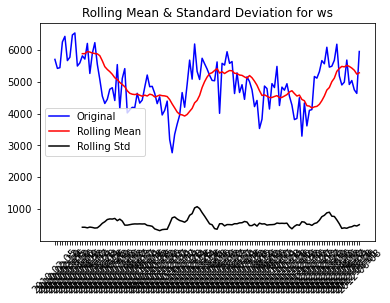

Results of Dickey-Fuller Test:
Test Statistic                  -3.158372
p-value                          0.022524
# Lags Used                      1.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


In [38]:
test_stationarity(train_X,"ws")

In [39]:
def log_trans(df,ts):return df[ts].apply(lambda x:np.log(x))

In [40]:
def plot_decomposition(df, ts,trend,seasonal, residual):

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
  plt.show()

In [41]:
train_X["ws_log"]=  log_trans(train_X,"ws")

In [42]:
decomposition = seasonal_decompose(train_X["ws_log"],  model ="additive" , period=48, extrapolate_trend=4)

In [43]:
New_Df= train_X
New_Df.loc[:,"trend"]= decomposition.trend
New_Df.loc[:,"seasonal"]= decomposition.seasonal
New_Df.loc[:,"resid"] = decomposition.resid

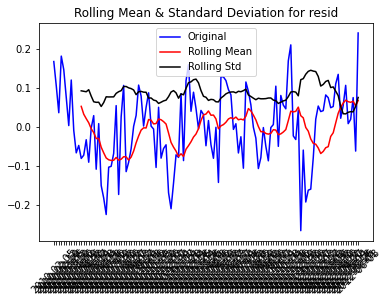

Results of Dickey-Fuller Test:
Test Statistic                  -4.304687
p-value                          0.000436
# Lags Used                      3.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [44]:
test_stationarity(New_Df, "resid")

In [45]:
decomposition.seasonal

Date
2010-02-05   -0.194725
2010-02-12   -0.175138
2010-02-19   -0.094725
2010-02-26   -0.093905
2010-03-05   -0.023717
                ...   
2012-05-11    0.063307
2012-05-18    0.078749
2012-05-25   -0.035192
2012-06-01    0.079747
2012-06-08    0.028467
Name: seasonal, Length: 123, dtype: float64

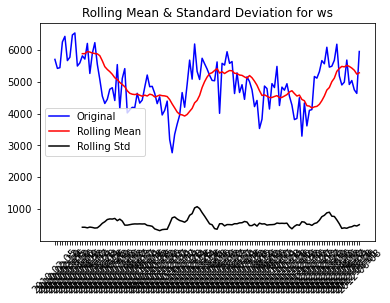

Results of Dickey-Fuller Test:
Test Statistic                  -3.158372
p-value                          0.022524
# Lags Used                      1.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


In [46]:
test_stationarity(New_Df, "ws")

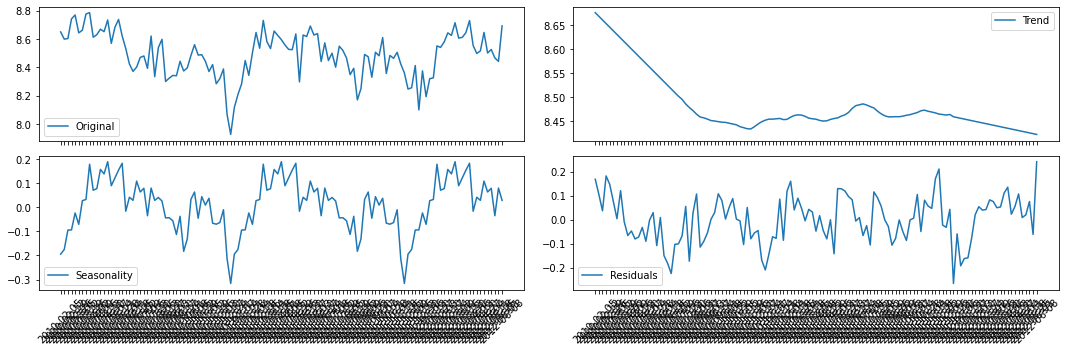

In [47]:
plot_decomposition(New_Df, ts = "ws_log",trend ="trend",seasonal= "seasonal",residual= "resid")

In [48]:
def run_arima(df,ts,p,d,q):
  model = ARIMA(df[ts], order = (p,d,q))
  results_arima = model.fit(disp=1)

  len_results = len(results_arima.fittedvalues)
  ts_modified = df[ts][-len_results:]
  rss = sum((results_arima.fittedvalues -ts_modified)**2)
  rmse = np.sqrt(rss/len(df[ts]))
  print("rmse:",rmse)
  plt.figure()
  plt.plot(df[ts])
  plt.plot(results_arima.fittedvalues, color = "red")

  plt.show()

  return results_arima

In [49]:
New_Df = New_Df.fillna(0)

C:\Users\Field Employee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


rmse: 0.07750230192196339


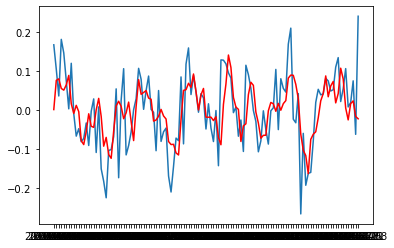

In [50]:
model_Ar = run_arima(df=New_Df, ts = "resid",p =15,d= 0, q=0)

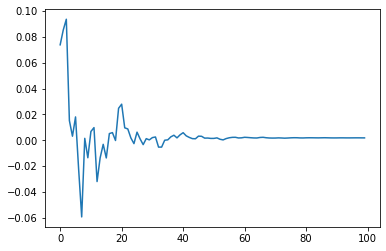

In [51]:
plt.figure()
plt.plot(model_Ar.forecast(100)[0])

In [52]:
#plt.figure()
ter = model_Ar.forecast(20)

In [53]:
tder = pd.DataFrame(ter)

In [54]:
tder

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0738235,0.0852385,0.0935918,0.0152671,0.00318814,0.018098,-0.0220488,-0.0591944,0.00153662,-0.0134727,0.00682443,0.00983577,-0.031872,-0.0135703,-0.00309189,-0.0136116,0.00521642,0.00596647,-0.000133946,0.0247608
1,0.0766057,0.0793531,0.0857497,0.0925249,0.093134,0.0934114,0.0935982,0.0938607,0.0951315,0.0951839,0.0952442,0.0952512,0.0954116,0.096237,0.0963446,0.096511,0.0967429,0.0967432,0.0967461,0.0967464
2,"[-0.07632094094231395, 0.22396797108502176]","[-0.07029067720097229, 0.2407675850120913]","[-0.07447447660035193, 0.26165810798096933]","[-0.1660784463197612, 0.19661259953268584]","[-0.17935122397580736, 0.1857275002252652]","[-0.1649851135904184, 0.20118103470293575]","[-0.20549792569312766, 0.161400238942947]","[-0.24315799101945024, 0.12476917880709983]","[-0.18491776413811792, 0.18799100907574726]","[-0.20002961373633546, 0.17308422517579283]","[-0.17985085591674663, 0.19349970739901842]","[-0.17685311519963784, 0.19652465278686346]","[-0.21887518903155567, 0.155131227635662]","[-0.20219134679638706, 0.17505072063471855]","[-0.19192387298596653, 0.18574008715388274]","[-0.20276979465440867, 0.17554649541699005]","[-0.1843961756078718, 0.19482900681070292]","[-0.1836467105486245, 0.1955796427190258]","[-0.18975279999001343, 0.18948490792618444]","[-0.16485866777376512, 0.21438018310618323]"


## PROPHET ::: HAIL MARY

In [55]:
from fbprophet import Prophet

In [56]:
sales = ['Date', 'Weekly_Sales']
df = dept_df[sales]
#Xs.set_index("Date", inplace = True)

In [57]:
df = df.rename(columns={"Date":"ds", "Weekly_Sales":"y"})
df.head()

,ds,y
0,2010-02-05,5711.57
1,2010-02-12,5427.79
2,2010-02-19,5451.57
3,2010-02-26,6262.36
4,2010-03-05,6437.56


In [58]:
# fit data using prophet
#m = Prophet(weekly_seasonality=True)
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
# Python
future = m.make_future_dataframe(periods=20)
future.tail()

,ds
158,2012-11-11
159,2012-11-12
160,2012-11-13
161,2012-11-14
162,2012-11-15


In [60]:
# Python
forecast = m.predict(future)
red = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
red

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,5178.741139,4679.009784,5682.672025
1,2010-02-12,5560.105116,5033.900739,6051.245205
2,2010-02-19,5835.363581,5300.786111,6334.129121
3,2010-02-26,5944.568795,5439.085739,6427.917995
4,2010-03-05,5944.619747,5422.125943,6420.782616
...,...,...,...,...
158,2012-11-11,4619.798935,4101.291464,5141.592779
159,2012-11-12,4586.915274,4080.686059,5092.210693
160,2012-11-13,4553.917887,4025.203871,5049.198506
161,2012-11-14,4521.309071,4069.399540,4994.749989


In [61]:
red.to_csv('./input/res.csv')

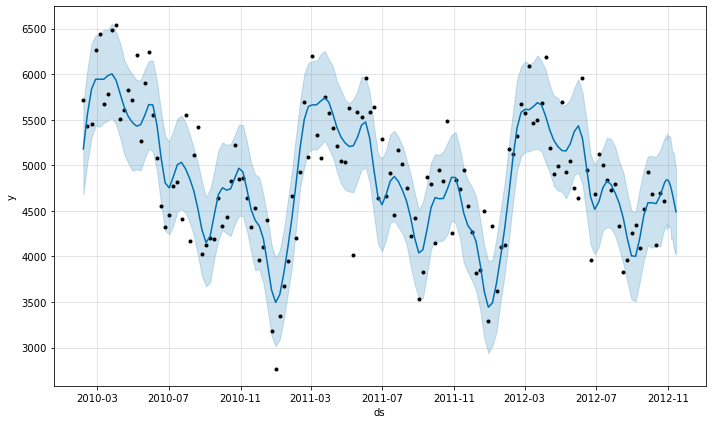

In [62]:
# Python
fig1 = m.plot(forecast)

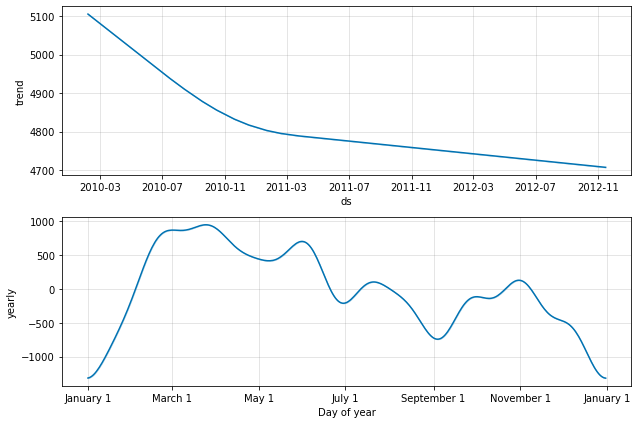

In [63]:
# Python
fig2 = m.plot_components(forecast)